In [2]:
import jsonlines
import os
import pandas as pd
import pickle
import re
import json
import random

def replace_semicolon(text, threshold=10):
    '''
    Get rid of semicolons.
    First split text into fragments between the semicolons. If the fragment 
    is longer than the threshold, turn the semicolon into a period. O.w treat
    it as a comma.
    Returns new text
    '''
    new_text = ""
    for subset in re.split(';', text):
        subset = subset.strip() # Clear off spaces
        # Check word count
        if len(subset.split()) > threshold:
            # Turn first char into uppercase
            new_text += ". " + subset[0].upper() + subset[1:]
        else:
            # Just append with a comma 
            new_text += ", " + subset

    return new_text

USC_re = re.compile('[Uu]\.*[Ss]\.*[Cc]\.]+')
PAREN_re = re.compile('\([^(]+\ [^\(]+\)')
BAD_PUNCT_RE = re.compile(r'([%s])' % re.escape('"#%&\*\+/<=>@[\]^{|}~_'), re.UNICODE)
BULLET_RE = re.compile('\n[\ \t]*`*\([a-zA-Z0-9]*\)')
DASH_RE = re.compile('--+')
WHITESPACE_RE = re.compile('\s+')
EMPTY_SENT_RE = re.compile('[,\.]\ *[\.,]')
FIX_START_RE = re.compile('^[^A-Za-z]*')
FIX_PERIOD = re.compile('\.([A-Za-z])')
SECTION_HEADER_RE = re.compile('SECTION [0-9]{1,2}\.|\nSEC\.* [0-9]{1,2}\.|Sec\.* [0-9]{1,2}\.')

FIX_PERIOD = re.compile('\.([A-Za-z])')

SECTION_HEADER_RE = re.compile('SECTION [0-9]{1,2}\.|\nSEC\.* [0-9]{1,2}\.|Sec\.* [0-9]{1,2}\.')

def clean_text(text):
    """
    Borrowed from the FNDS text processing with additional logic added in.
    Note: we do not take care of token breaking - assume SPACY's tokenizer
    will handle this for us.
    """

    # Indicate section headers, we need them for features
    text = SECTION_HEADER_RE.sub('SECTION-HEADER', text)
    # For simplicity later, remove '.' from most common acronym
    text = text.replace("U.S.", "US")
    text = text.replace('SEC.', 'Section')
    text = text.replace('Sec.', 'Section')
    text = USC_re.sub('USC', text)

    # Remove parantheticals because they are almost always references to laws 
    # We could add a special tag, but we just remove for now
    # Note we dont get rid of nested parens because that is a complex re
    #text = PAREN_re.sub('LAWREF', text)
    text = PAREN_re.sub('', text)
    

    # Get rid of enums as bullets or ` as bullets
    text = BULLET_RE.sub(' ',text)
    
    # Clean html 
    text = text.replace('&lt;all&gt;', '')

    # Remove annoying punctuation, that's not relevant
    text = BAD_PUNCT_RE.sub('', text)

    # Get rid of long sequences of dashes - these are formating
    text = DASH_RE.sub( ' ', text)

    # removing newlines, tabs, and extra spaces.
    text = WHITESPACE_RE.sub(' ', text)
    
    # If we ended up with "empty" sentences - get rid of them.
    text = EMPTY_SENT_RE.sub('.', text)
    
    # Attempt to create sentences from bullets 
    text = replace_semicolon(text)
    
    # Fix weird period issues + start of text weirdness
    #text = re.sub('\.(?=[A-Z])', '  . ', text)
    # Get rid of anything thats not a word from the start of the text
    text = FIX_START_RE.sub( '', text)
    # Sometimes periods get formatted weird, make sure there is a space between periods and start of sent   
    text = FIX_PERIOD.sub(". \g<1>", text)

    # Fix quotes
    text = text.replace('``', '"')
    text = text.replace('\'\'', '"')

    # Add special punct back in
    text = text.replace('SECTION-HEADER', '<SECTION-HEADER>')

    return text

## First data set: US train

In [4]:
# Read data
new_data = pd.read_json('data/us_train_data_final.jsonl', lines=True)

In [5]:
# Pre-process
new_data['clean_text'] = new_data.text.map(clean_text)        
new_data['clean_summary'] = new_data.summary.map(clean_text)
new_data['clean_title'] = new_data.title.map(clean_text)

In [6]:
# Write resulting dataset
new_data.to_json('data/us_train_data_final_clean.jsonl', lines=True, orient='records')

In [42]:
# Read back and confirm that everything is fine
new_data_clean = pd.read_json('data/us_train_data_final_clean.jsonl', lines=True)

In [43]:
# Example: first row
new_data_clean.loc[0,'clean_text']

'<SECTION-HEADER> SHORT TITLE. This Act may be cited as the "South Utah Valley Electric Conveyance Act". <SECTION-HEADER> DEFINITIONS. In this Act: District. The term "District" means the South Utah Valley Electric Service District, organized under the laws of the State of Utah. Electric distribution system. The term "Electric Distribution System" means fixtures, irrigation, or power facilities lands, distribution fixture lands, and shared power poles. Fixtures. The term "fixtures" means all power poles, cross-members, wires, insulators and associated fixtures, including substations, that comprise those portions of the Strawberry Valley Project power distribution system that are rated at a voltage of 12.5 kilovolts and were constructed with Strawberry Valley Project revenues. And any such fixtures that are located on Federal lands and interests in lands. Irrigation or power facilities lands. The term "irrigation or power facilities lands" means all Federal lands and interests in lands 

In [44]:
# Get corresponding sentences
new_data_clean['clean_sentences'] = 0
# Convert to object data to be able to assign a list
new_data_clean['clean_sentences'] = new_data_clean['clean_sentences'].astype(object)
size_new_data_clean = new_data_clean.shape[0]

In [45]:
# Split text into sentences
print(size_new_data_clean)
for i in range(size_new_data_clean):
    sentences = new_data_clean.loc[i,'clean_text'].split(". ")
    new_data_clean.iat[i,new_data_clean.columns.get_loc('clean_sentences')] = sentences

28408


In [46]:
# Sanity check
new_data_clean.loc[1000,'clean_sentences']

['<SECTION-HEADER> SHORT TITLE',
 'This Act may be cited as the "Legacy IRA Act"',
 '<SECTION-HEADER> TAX-FREE DISTRIBUTIONS FROM INDIVIDUAL RETIREMENT ACCOUNTS FOR CHARITABLE PURPOSES',
 'In General',
 'Paragraph (8) of section 408(d) of the Internal Revenue Code of 1986 is amended to read as follows: Distributions for charitable purposes',
 'In general',
 'No amount shall be includible in gross income by reason of a qualified charitable distribution',
 'Limitations',
 'In general',
 'The aggregate amount excluded from gross income by subparagraph (A) for a taxable year shall not exceed $400,000',
 'Organization and entity specific limitations',
 'The amount excluded from gross income by subparagraph (A) for a taxable year shall not exceed $100,000, in the case of any distribution described in subparagraph (i)(I), and $400,000, in the case of any distribution described in subparagraph (i)(II)',
 'Qualified charitable distribution',
 "For purposes of this paragraph, the term `qualified

In [47]:
# Write results
new_data_clean.to_json('data/us_train_data_final_clean_with_sentences.jsonl', lines=True, orient='records')

In [48]:
# Read one last time and confirm that everything is fine
new_data_clean_with_sentences = pd.read_json('data/us_train_data_final_clean_with_sentences.jsonl', lines=True)

In [49]:
# Example: first row
new_data_clean_with_sentences.loc[0,"clean_sentences"]

['<SECTION-HEADER> SHORT TITLE',
 'This Act may be cited as the "South Utah Valley Electric Conveyance Act"',
 '<SECTION-HEADER> DEFINITIONS',
 'In this Act: District',
 'The term "District" means the South Utah Valley Electric Service District, organized under the laws of the State of Utah',
 'Electric distribution system',
 'The term "Electric Distribution System" means fixtures, irrigation, or power facilities lands, distribution fixture lands, and shared power poles',
 'Fixtures',
 'The term "fixtures" means all power poles, cross-members, wires, insulators and associated fixtures, including substations, that comprise those portions of the Strawberry Valley Project power distribution system that are rated at a voltage of 12.5 kilovolts and were constructed with Strawberry Valley Project revenues',
 'And any such fixtures that are located on Federal lands and interests in lands',
 'Irrigation or power facilities lands',
 'The term "irrigation or power facilities lands" means all Fed

## Second data set: US test

In [17]:
# Read data
new_data_2 = pd.read_json('data/us_test_data_final.jsonl', lines=True)

In [18]:
# Pre-process
new_data_2['clean_text'] = new_data_2.text.map(clean_text)        
new_data_2['clean_summary'] = new_data_2.summary.map(clean_text)
new_data_2['clean_title'] = new_data_2.title.map(clean_text)

In [19]:
# Write resulting dataset
new_data_2.to_json('data/us_test_data_final_clean.jsonl', lines=True, orient='records')

In [20]:
# Read back and confirm that everything is fine
new_data_2_clean = pd.read_json('data/us_test_data_final_clean.jsonl', lines=True)

In [21]:
# Example: first row
new_data_2_clean.loc[0,'clean_text']

'<SECTION-HEADER> SHORT TITLE. This Act may be cited as the "Public Safety Officers\' Benefits Improvement Act of 2016". <SECTION-HEADER> REPORTS. Section 1205 of title I of the Omnibus Crime Control and Safe Streets Act of 1968 is amended in subsection (a), by inserting "Rules, regulations, and procedures issued under this part may include regulations based on standards developed by another Federal agency for programs related to public safety officer death or disability claims." before the last sentence, in subsection (b) by inserting "(1)" before "In making". And by adding at the end the following: In making a determination under section 1201, the Bureau shall give substantial weight to the evidence and all findings of fact presented by a State, local, or Federal administrative or investigative agency regarding eligibility for death or disability benefits.". And by adding at the end the following: (1)(A) Not later than 30 days after the date of enactment of this subsection, the Burea

In [22]:
# Get corresponding sentences
new_data_2_clean['clean_sentences'] = 0
# Convert to object data to be able to assign a list
new_data_2_clean['clean_sentences'] = new_data_2_clean['clean_sentences'].astype(object)
size_new_data_2_clean = new_data_2_clean.shape[0]

In [23]:
# Split text into sentences
print(size_new_data_2_clean)
for i in range(size_new_data_2_clean):
    sentences = new_data_2_clean.loc[i,'clean_text'].split(". ")
    new_data_2_clean.iat[i,new_data_2_clean.columns.get_loc('clean_sentences')] = sentences

5014


In [24]:
# Sanity check
new_data_2_clean.loc[1000,'clean_sentences']

['<SECTION-HEADER> SHORT TITLE',
 'This Act may be cited as the "Veterans Advocacy Act of 2007"',
 '<SECTION-HEADER> PILOT PROGRAM ON PROVISION OF LEGAL ASSISTANCE TO ASSIST VETERANS AND MEMBERS OF THE ARMED FORCES RECEIVE HEALTH CARE, BENEFITS, AND SERVICES',
 'Pilot Program Required',
 'In general',
 'The Secretary of Veterans Affairs shall carry out a pilot program to assess the feasibility and advisability of utilizing eligible entities to provide legal services to assist veterans and members of the Armed Forces in applying for and receiving health care, benefits, and services',
 'Consultation',
 'The Secretary of Veterans Affairs shall carry out the pilot program in consultation with the Secretary of Defense',
 'Grants',
 'In general',
 'The Secretary of Veterans Affairs shall carry out the pilot program through the award of grants to eligible entities selected by the panel established in accordance with subsection (d)(1) for the provision of legal services at no cost to members o

In [25]:
# Write results
new_data_2_clean.to_json('data/us_test_data_final_clean_with_sentences.jsonl', lines=True, orient='records')

In [26]:
# Read one last time and confirm that everything is fine
new_data_2_clean_with_sentences = pd.read_json('data/us_test_data_final_clean_with_sentences.jsonl', lines=True)

In [27]:
# Example: first row
new_data_2_clean_with_sentences.loc[0,"clean_sentences"]

['<SECTION-HEADER> SHORT TITLE',
 'This Act may be cited as the "Public Safety Officers\' Benefits Improvement Act of 2016"',
 '<SECTION-HEADER> REPORTS',
 'Section 1205 of title I of the Omnibus Crime Control and Safe Streets Act of 1968 is amended in subsection (a), by inserting "Rules, regulations, and procedures issued under this part may include regulations based on standards developed by another Federal agency for programs related to public safety officer death or disability claims." before the last sentence, in subsection (b) by inserting "(1)" before "In making"',
 'And by adding at the end the following: In making a determination under section 1201, the Bureau shall give substantial weight to the evidence and all findings of fact presented by a State, local, or Federal administrative or investigative agency regarding eligibility for death or disability benefits."',
 'And by adding at the end the following: (1)(A) Not later than 30 days after the date of enactment of this subse

## Third dataset: CA test

In [28]:
# Read data
new_data_3 = pd.read_json('data/ca_test_data_final.jsonl', lines=True)

In [29]:
# Pre-process
new_data_3['clean_text'] = new_data_3.text.map(clean_text)        
new_data_3['clean_summary'] = new_data_3.summary.map(clean_text)
new_data_3['clean_title'] = new_data_3.title.map(clean_text)

In [30]:
# Write resulting dataset
new_data_3.to_json('data/ca_test_data_final_clean.jsonl', lines=True, orient='records')

In [31]:
# Read back and confirm that everything is fine
new_data_3_clean = pd.read_json('data/ca_test_data_final_clean.jsonl', lines=True)

In [32]:
# Example: first row
new_data_3_clean.loc[0,'clean_text']

'The people of the State of California do enact as follows: <SECTION-HEADER> The Legislature finds and declares all of the following: (1) Since 1899 congressionally chartered veterans’ organizations have provided a valuable service to our nation’s returning service members. These organizations help preserve the memories and incidents of the great hostilities fought by our nation, and preserve and strengthen comradeship among members. These veterans’ organizations also own and manage various properties including lodges, posts, and fraternal halls. These properties act as a safe haven where veterans of all ages and their families can gather together to find camaraderie and fellowship, share stories, and seek support from people who understand their unique experiences. This aids in the healing process for these returning veterans, and ensures their health and happiness. As a result of congressional chartering of these veterans’ organizations, the United States Internal Revenue Service cre

In [33]:
# Get corresponding sentences
new_data_3_clean['clean_sentences'] = 0
# Convert to object data to be able to assign a list
new_data_3_clean['clean_sentences'] = new_data_3_clean['clean_sentences'].astype(object)
size_new_data_3_clean = new_data_3_clean.shape[0]

In [34]:
# Split text into sentences
print(size_new_data_3_clean)
for i in range(size_new_data_3_clean):
    sentences = new_data_3_clean.loc[i,'clean_text'].split(". ")
    new_data_3_clean.iat[i,new_data_3_clean.columns.get_loc('clean_sentences')] = sentences

1237


In [35]:
# Sanity check
new_data_3_clean.loc[1000,'clean_sentences']

['The people of the State of California do enact as follows: <SECTION-HEADER> Section 56804 of the Government Code is amended to read: 56804',
 'For any proposal that includes a disincorporation, the executive officer shall prepare, or cause to be prepared by contract, a comprehensive fiscal analysis',
 'This analysis shall become part of the report required pursuant to Section 56665',
 'Data used for the analysis shall be from the most recent fiscal year for which data is available, preceding the issuances of the certificate of filing',
 'When data requested by the executive officer in the notice to affected agencies, pursuant to paragraph (2) of subdivision (b) of Section 56658, is unavailable, the analysis shall document the source and methodology of the data used',
 'The analysis shall review and document each of the following: The direct and indirect costs incurred by the city proposed for disincorporation for providing public services during the three fiscal years immediately pre

In [36]:
# Write results
new_data_3_clean.to_json('data/ca_test_data_final_clean_with_sentences.jsonl', lines=True, orient='records')

In [37]:
# Read one last time and confirm that everything is fine
new_data_3_clean_with_sentences = pd.read_json('data/ca_test_data_final_clean_with_sentences.jsonl', lines=True)

In [38]:
# Example: first row
new_data_3_clean_with_sentences.loc[0,"clean_sentences"]

['The people of the State of California do enact as follows: <SECTION-HEADER> The Legislature finds and declares all of the following: (1) Since 1899 congressionally chartered veterans’ organizations have provided a valuable service to our nation’s returning service members',
 'These organizations help preserve the memories and incidents of the great hostilities fought by our nation, and preserve and strengthen comradeship among members',
 'These veterans’ organizations also own and manage various properties including lodges, posts, and fraternal halls',
 'These properties act as a safe haven where veterans of all ages and their families can gather together to find camaraderie and fellowship, share stories, and seek support from people who understand their unique experiences',
 'This aids in the healing process for these returning veterans, and ensures their health and happiness',
 'As a result of congressional chartering of these veterans’ organizations, the United States Internal Rev

In [39]:
# A few weird symbols...
new_data_3.loc[0,'text']

'The people of the State of California do enact as follows:\n\n\nSECTION 1.\nThe Legislature finds and declares all of the following:\n(a) (1) Since 1899 congressionally chartered veterans’ organizations have provided a valuable service to our nation’s returning service members. These organizations help preserve the memories and incidents of the great hostilities fought by our nation, and preserve and strengthen comradeship among members.\n(2) These veterans’ organizations also own and manage various properties including lodges, posts, and fraternal halls. These properties act as a safe haven where veterans of all ages and their families can gather together to find camaraderie and fellowship, share stories, and seek support from people who understand their unique experiences. This aids in the healing process for these returning veterans, and ensures their health and happiness.\n(b) As a result of congressional chartering of these veterans’ organizations, the United States Internal Reve

# Baseline measures

In [50]:
ls data/

README.md
ca_test_data_final.jsonl
ca_test_data_final_clean.jsonl
ca_test_data_final_clean_with_sentences.jsonl
us_test_data_final.jsonl
us_test_data_final_clean.jsonl
us_test_data_final_clean_with_sentences.jsonl
us_train_data_final.jsonl
us_train_data_final_clean.jsonl
us_train_data_final_clean_with_sentences.jsonl


In [78]:
#load data
data = []
with open('data/us_test_data_final_clean_with_sentences.jsonl') as f:
    for line in f:
        data.append(json.loads(line))
df_data = pd.DataFrame(data)

In [79]:
# Some basic cleaning in the text (remove extra spaces, --, and \n)
list_text = []
for i in range(0,len(df_data)):
    text = str(df_data.iloc[i]["text"])
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = re.sub('--', ' ', text)
    list_text.append(text)

df_data2 = df_data
df_data2["text2"] = list_text

Summary based on k random words

In [80]:
def summary_k_random_words(k):
    list_summary = [] 
    for i in range(0,len(df_data2)):
        list_inter = []
        text = str(df_data2.iloc[i]["text2"])
        words = text.split()
        for t in range(0,k):
            list_inter.append(random.choice(words))
        summary = ' '.join(list_inter)
        list_summary.append(summary)
    return list_summary

In [81]:
list_summary = summary_k_random_words(100)
df_data2["summary_100_words"] = list_summary

Summary based on k first sentences in the text

In [82]:
def summary_k_first_sentences(k):
    list_summary_first_sentences = []
    for i in range(0,len(df_data2)):
        list_sentences = df_data2.iloc[i]["clean_sentences"][1:k+1]
        summary = " ".join(list_sentences)
        list_summary_first_sentences.append(summary)
    return list_summary_first_sentences

In [83]:
list_summary_k_first_sentences = summary_k_first_sentences(10)
df_data2["summary_10_first_sentences"] = list_summary_k_first_sentences

Summary based on k sentences picked at random

In [84]:
def summary_k_sentences_at_random(k):
    list_summary_k_random_sentences = []
    for i in range(0,len(df_data2)):
        test = df_data2.iloc[i]["clean_sentences"]
        list_random_sentences = []
        for i in range(0,k):
            list_random_sentences.append(random.choice(test))
        list_summary_k_random_sentences.append(" ".join(list_random_sentences))
    return list_summary_k_random_sentences

In [85]:
list_summary_k_sentences_at_random = summary_k_sentences_at_random(10)
df_data2["summary_10_sentences_at_random"] = list_summary_k_sentences_at_random

Summary based on k sentences picked in the text, but keeping the order

In [86]:
def summary_k_random_sentences_keep_order(k):
    list_summary_k_random_sentences_keep_order = []
    for i in range(0,len(df_data2)):
        test = df_data2.iloc[i]["clean_sentences"]
        if len(test)>10:
            indices = random.sample(range(len(test)), 10)
            list_test = [test[i] for i in sorted(indices)]
            list_summary_k_random_sentences_keep_order.append(" ".join(list_test))
        else:
            list_summary_k_random_sentences_keep_order.append(" ".join(test))
    return list_summary_k_random_sentences_keep_order

In [87]:
list_summary_k_random_sentences_keep_order = summary_k_random_sentences_keep_order(10)
df_data2["summary_10_sentences_at_random_keep_order"] = list_summary_k_random_sentences_keep_order

In [97]:
df_data2

,bill_id,summary,text,title,text_len,sum_len,clean_text,clean_summary,clean_title,clean_sentences,text2,summary_100_words,summary_10_first_sentences,summary_10_sentences_at_random,summary_10_sentences_at_random_keep_order
0,114_hr5743,Public Safety Officers' Benefits Improvement A...,SECTION 1. SHORT TITLE.\n\n This Act may be...,Public Safety Officers' Benefits Improvement A...,12792,1827,<SECTION-HEADER> SHORT TITLE. This Act may be ...,Public Safety Officers' Benefits Improvement A...,Public Safety Officers' Benefits Improvement A...,"[<SECTION-HEADER> SHORT TITLE, This Act may be...",SECTION 1. SHORT TITLE. This Act may be cited ...,the subparagraph final death number; of of Not...,"This Act may be cited as the ""Public Safety Of...",(A) Not later than 180 days after the date of ...,Section 1205 of title I of the Omnibus Crime C...
1,115_s2620,Federal Cyber Joint Duty Program Act of 2018 T...,SECTION 1. SHORT TITLE.\n\n This Act may be...,Federal Cyber Joint Duty Program Act of 2018,5828,659,<SECTION-HEADER> SHORT TITLE. This Act may be ...,Federal Cyber Joint Duty Program Act of 2018 T...,Federal Cyber Joint Duty Program Act of 2018,"[<SECTION-HEADER> SHORT TITLE, This Act may be...",SECTION 1. SHORT TITLE. This Act may be cited ...,The a Joint to may of the it employee agency t...,"This Act may be cited as the ""Federal Cyber Jo...","The term ""joint cyber position"" means a positi...",<SECTION-HEADER> DEFINITIONS In this Act: Agen...
2,106_s3020,"Prohibits the FCC, without specific authorizat...",SECTION 1. SHORT TITLE.\n\n This Act may be...,Radio Broadcasting Preservation Act of 2000,5676,879,<SECTION-HEADER> SHORT TITLE. This Act may be ...,"Prohibits the FCC, without specific authorizat...",Radio Broadcasting Preservation Act of 2000,"[<SECTION-HEADER> SHORT TITLE, This Act may be...",SECTION 1. SHORT TITLE. This Act may be cited ...,tests conclusion 301). rules the TO to to the ...,"This Act may be cited as the ""Radio Broadcasti...","Incumbent FM radio broadcasters in general, an...",<SECTION-HEADER> SHORT TITLE Congressional aut...
3,106_s130,Repeals the Internal Revenue Code's nonrefunda...,SECTION 1. DEPENDENT CARE TAX CREDIT.\n\n (...,A bill to amend the Internal Revenue Code of 1...,17190,615,<SECTION-HEADER> DEPENDENT CARE TAX CREDIT. De...,Repeals the Internal Revenue Code's nonrefunda...,A bill to amend the Internal Revenue Code of 1...,"[<SECTION-HEADER> DEPENDENT CARE TAX CREDIT, D...",SECTION 1. DEPENDENT CARE TAX CREDIT. (a) Depe...,section not beginning care the care striking p...,Dependent Care Services Subpart C of part IV o...,"Respite Care Expenses ""<SECTION-HEADER> Overpa...",In general In the case of an individual who ma...
4,103_hr181,Notch Baby Act of 1993 - Amends title II (Old ...,SECTION 1. SHORT TITLE.\n\n This Act may be...,Notch Baby Act of 1993,5649,319,<SECTION-HEADER> SHORT TITLE. This Act may be ...,Notch Baby Act of 1993 - Amends title II of th...,Notch Baby Act of 1993,"[<SECTION-HEADER> SHORT TITLE, This Act may be...",SECTION 1. SHORT TITLE. This Act may be cited ...,end eligible becomes which effective in of par...,"This Act may be cited as the ""Notch Baby Act o...",<SECTION-HEADER> SHORT TITLE No monthly benefi...,60 percent 1980............... 35 percent 1981...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,115_hr2900,"Synthetic Drug Prevention, Treatment, and Educ...",SECTION 1. SHORT TITLE.\n\n This Act may be...,"Synthetic Drug Prevention, Treatment, and Educ...",5002,1408,<SECTION-HEADER> SHORT TITLE. This Act may be ...,"Synthetic Drug Prevention, Treatment, and Educ...","Synthetic Drug Prevention, Treatment, and Educ...","[<SECTION-HEADER> SHORT TITLE, This Act may be...",SECTION 1. SHORT TITLE. This Act may be cited ...,"amount. paragraph, after of term the years wit...","This Act may be cited as the ""Synthetic Drug P...",The Secretary shall make the information in th...,<SECTION-HEADER> SHORT TITLE This Act may be c...
5010,112_hr2197,Justice 

# Evaluation

In [104]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allisontam/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [123]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english') + list(string.punctuation))

In [126]:
from rouge import Rouge 
# Run the below command. Assumes we're using conda
# pip install --extra-index-url https://pypi.org/project/rouge/ rouge

In [171]:
res = df_data2[['bill_id','title','clean_summary', 'summary_100_words',
                'summary_10_first_sentences', 'summary_10_sentences_at_random',
                'summary_10_sentences_at_random_keep_order']]
res

,bill_id,title,clean_summary,summary_100_words,summary_10_first_sentences,summary_10_sentences_at_random,summary_10_sentences_at_random_keep_order
0,114_hr5743,Public Safety Officers' Benefits Improvement A...,Public Safety Officers' Benefits Improvement A...,the subparagraph final death number; of of Not...,"This Act may be cited as the ""Public Safety Of...",(A) Not later than 180 days after the date of ...,Section 1205 of title I of the Omnibus Crime C...
1,115_s2620,Federal Cyber Joint Duty Program Act of 2018,Federal Cyber Joint Duty Program Act of 2018 T...,The a Joint to may of the it employee agency t...,"This Act may be cited as the ""Federal Cyber Jo...","The term ""joint cyber position"" means a positi...",<SECTION-HEADER> DEFINITIONS In this Act: Agen...
2,106_s3020,Radio Broadcasting Preservation Act of 2000,"Prohibits the FCC, without specific authorizat...",tests conclusion 301). rules the TO to to the ...,"This Act may be cited as the ""Radio Broadcasti...","Incumbent FM radio broadcasters in general, an...",<SECTION-HEADER> SHORT TITLE Congressional aut...
3,106_s130,A bill to amend the Internal Revenue Code of 1...,Repeals the Internal Revenue Code's nonrefunda...,section not beginning care the care striking p...,Dependent Care Services Subpart C of part IV o...,"Respite Care Expenses ""<SECTION-HEADER> Overpa...",In general In the case of an individual who ma...
4,103_hr181,Notch Baby Act of 1993,Notch Baby Act of 1993 - Amends title II of th...,end eligible becomes which effective in of par...,"This Act may be cited as the ""Notch Baby Act o...",<SECTION-HEADER> SHORT TITLE No monthly benefi...,60 percent 1980............... 35 percent 1981...
...,...,...,...,...,...,...,...
5009,115_hr2900,"Synthetic Drug Prevention, Treatment, and Educ...","Synthetic Drug Prevention, Treatment, and Educ...","amount. paragraph, after of term the years wit...","This Act may be cited as the ""Synthetic Drug P...",The Secretary shall make the information in th...,<SECTION-HEADER> SHORT TITLE This Act may be c...
5010,112_hr2197,To amend the Omnibus Crime Control and Safe St...,Justice for Rape Victims and Improving Use of ...,"study, or information to reduce or to ``(i) DN...","This Act may be cited as the ""Justice for Rape...",DNA samples that have been received by a publi...,In general Information contained in such datab...
5011,110_s3132,A bill to amend the Internal Revenue Code of 1...,Accelerating Carbon Capture and Sequestration ...,"year States 38(b) (32), 2. natural subsection ...","This Act may be cited as the ""Accelerating Car...",The amendments made by this section shall appl...,General Rule For purposes of this section In g...
5012,106_s1,Election Reform Act,Transfers to the Commission: (1) all functions...,known shall practices employee once duties hav...,"This Act may be cited as the ""Election Reform ...",Administrative Support Services Postal Service...,Grant Program Not less often than once each ca...


In [177]:
def cleaner(text):
    clean = [lemmatizer.lemmatize(word).lower() for word in text.split(' ') if word not in stop]
    return ' '.join(clean)
    
def prep_dataset(df, baselines):
    '''
    Removes stopwords and applies lemmatizer to summaries before evaluation
    '''
    for i, row in df.iterrows():
        truth = row['clean_summary']
        # Removes title from clean_summary if it exists
        if row['title'] == truth[:len(row['title'])]:
            df.at[i,'clean_summary'] = truth[len(row['title']):]
    for col in baselines:
        df[col] = df[col].apply(cleaner)
    cols = ['bill_id', 'clean_summary']
    cols.extend(baselines)
    return df[cols]

def clean_rouge(df, metric='f'):
    rouge = Rouge()
    baselines = ['summary_100_words',
        'summary_10_first_sentences', 'summary_10_sentences_at_random',
        'summary_10_sentences_at_random_keep_order']
    df = prep_dataset(df.copy(), baselines)
    ret = {'bill_id': list(df['bill_id'])}
    truth = list(df['clean_summary'])
    
    for summary_type in baselines:
        scores = rouge.get_scores(list(df[summary_type]), truth)
        ret[summary_type+"_R1"] = [score['rouge-1'][metric] for score in scores]
        ret[summary_type+"_R2"] = [score['rouge-2'][metric] for score in scores]
        ret[summary_type+"_RL"] = [score['rouge-l'][metric] for score in scores]
    return ret

In [178]:
metrics = clean_rouge(res)
pd.DataFrame(metrics)

,bill_id,summary_100_words_R1,summary_100_words_R2,summary_100_words_RL,summary_10_first_sentences_R1,summary_10_first_sentences_R2,summary_10_first_sentences_RL,summary_10_sentences_at_random_R1,summary_10_sentences_at_random_R2,summary_10_sentences_at_random_RL,summary_10_sentences_at_random_keep_order_R1,summary_10_sentences_at_random_keep_order_R2,summary_10_sentences_at_random_keep_order_RL
0,114_hr5743,0.142857,0.000000,0.088143,0.285714,0.050761,0.262683,0.278884,0.043478,0.258641,0.196970,0.021164,0.188853
1,115_s2620,0.222222,0.033058,0.200000,0.183673,0.015873,0.140990,0.282828,0.089552,0.258390,0.211538,0.061069,0.129988
2,106_s3020,0.244604,0.000000,0.188338,0.254777,0.029268,0.159981,0.235294,0.035714,0.187407,0.322581,0.042735,0.224976
3,106_s130,0.162162,0.000000,0.159068,0.271429,0.081395,0.221372,0.188406,0.022099,0.169419,0.150376,0.011976,0.118688
4,103_hr181,0.098765,0.000000,0.070532,0.137405,0.025316,0.077686,0.142857,0.024096,0.082324,0.141593,0.028369,0.111161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,115_hr2900,0.200000,0.000000,0.162300,0.212290,0.016194,0.143425,0.196319,0.017167,0.132435,0.111888,0.019704,0.078163
5010,112_hr2197,0.116883,0.000000,0.087255,0.300469,0.071429,0.261977,0.159624,0.013889,0.102920,0.169492,0.024000,0.118887
5011,110_s3132,0.089888,0.000000,0.083976,0.262295,0.054422,0.140047,0.164948,0.031250,0.128342,0.115942,0.012048,0.052804
5012,106_s1,0.069767,0.000000,0.062135,0.085470,0.000000,0.038255,0.034188,0.000000,0.025503,0.017699,0.000000,0.013444


In [180]:
metrics = pd.DataFrame(metrics)
metrics.to_csv('results/us_test_results.csv')

# Visualizations

In [182]:
import matplotlib.pyplot as plt

In [ ]:
baselines = ['summary_100_words',
    'summary_10_first_sentences', 'summary_10_sentences_at_random',
    'summary_10_sentences_at_random_keep_order']

In [189]:
plot = metrics.drop('bill_id',axis=1)
labels = plot.columns
list(labels)

['summary_100_words_R1',
 'summary_100_words_R2',
 'summary_100_words_RL',
 'summary_10_first_sentences_R1',
 'summary_10_first_sentences_R2',
 'summary_10_first_sentences_RL',
 'summary_10_sentences_at_random_R1',
 'summary_10_sentences_at_random_R2',
 'summary_10_sentences_at_random_RL',
 'summary_10_sentences_at_random_keep_order_R1',
 'summary_10_sentences_at_random_keep_order_R2',
 'summary_10_sentences_at_random_keep_order_RL']

Text(0.5, 1.0, 'Overall Summary')

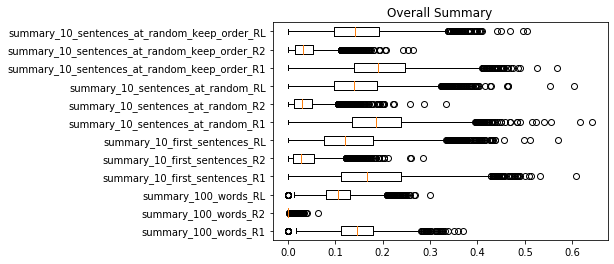

In [193]:
plt.boxplot(plot.to_numpy(),labels=list(labels),vert=False)
plt.title('Overall Summary')

Text(0.5, 1.0, 'Rouge-L metric')

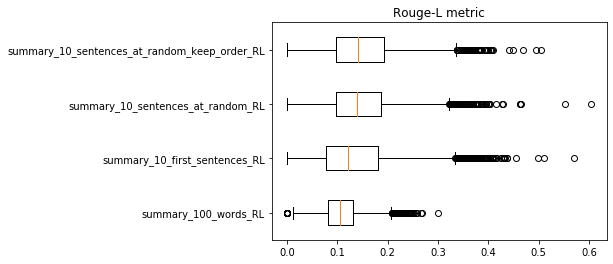

In [194]:
plot2 = metrics[['summary_100_words_RL', 'summary_10_first_sentences_RL',
                 'summary_10_sentences_at_random_RL','summary_10_sentences_at_random_keep_order_RL']]
plt.boxplot(plot2.to_numpy(),labels=list(plot2.columns),vert=False)
plt.title('Rouge-L metric')

In [196]:
plot2.mean()

summary_100_words_RL                            0.107694
summary_10_first_sentences_RL                   0.136873
summary_10_sentences_at_random_RL               0.146877
summary_10_sentences_at_random_keep_order_RL    0.148610
dtype: float64